In [1]:
#Data_Collection_and_Preprocessing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [3]:
# Set path to dataset folder
data_dir = 'dataset'  # This works now because the folder exists!

# Image properties
img_height = 128
img_width = 128
batch_size = 32

# Load training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


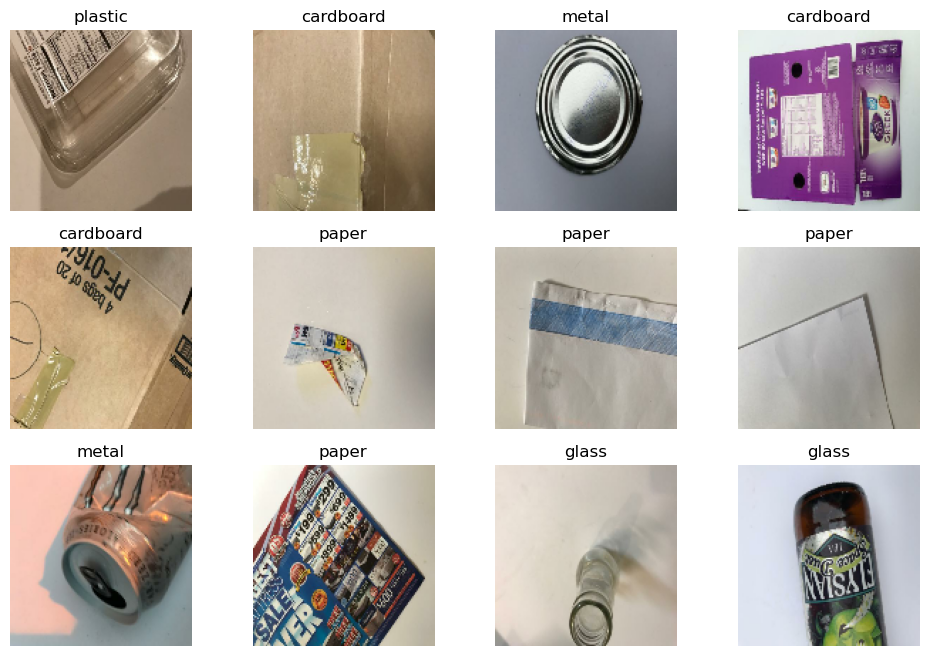

In [4]:
# View class names
class_names = train_ds.class_names
print("Class Names:", class_names)

# Plot some sample images from training dataset
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):  # take 1 batch
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

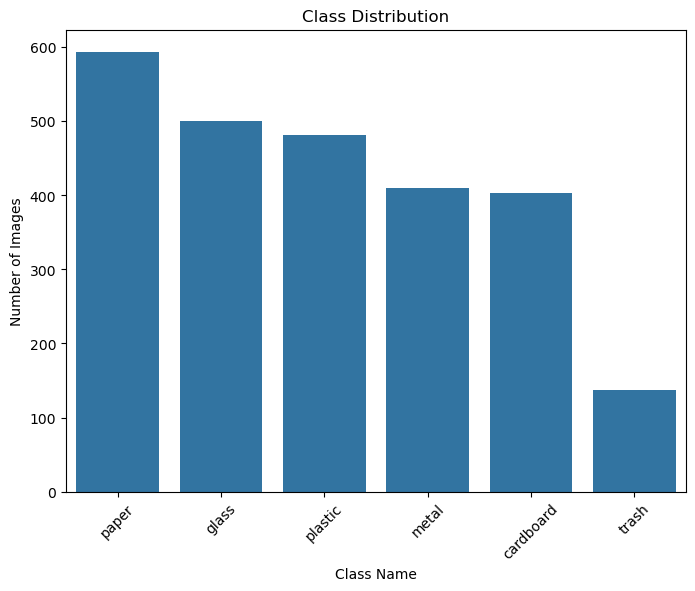

           Image Count
paper              594
glass              501
plastic            482
metal              410
cardboard          403
trash              137


In [5]:
import os
import pandas as pd

# Path to dataset
data_path = 'dataset'

# Count images per class
class_counts = {}
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Show class distribution
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
df = df.sort_values(by='Image Count', ascending=False)

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=df.index, y=df['Image Count'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.xticks(rotation=45)
plt.show()

print(df)

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract class names
class_names = train_ds.class_names
print("Classes:", class_names)

# Count number of images per class again
num_images_per_class = []
for class_name in class_names:
    folder = os.path.join(data_path, class_name)
    num_images = len(os.listdir(folder))
    num_images_per_class.append(num_images)

# Convert class labels to integers (0 to 5)
class_indices = np.arange(len(class_names))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_indices,
    y=np.repeat(class_indices, num_images_per_class)
)

# Convert to dictionary
class_weights_dict = dict(zip(class_indices, class_weights))

# Show class weights
print("\nComputed Class Weights:")
for i, weight in class_weights_dict.items():
    print(f"{class_names[i]}: {weight:.2f}")

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Computed Class Weights:
cardboard: 1.05
glass: 0.84
metal: 1.03
paper: 0.71
plastic: 0.87
trash: 3.07


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Data Augmentation Layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Prefetch for performance boost
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

# Prefetching for training performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

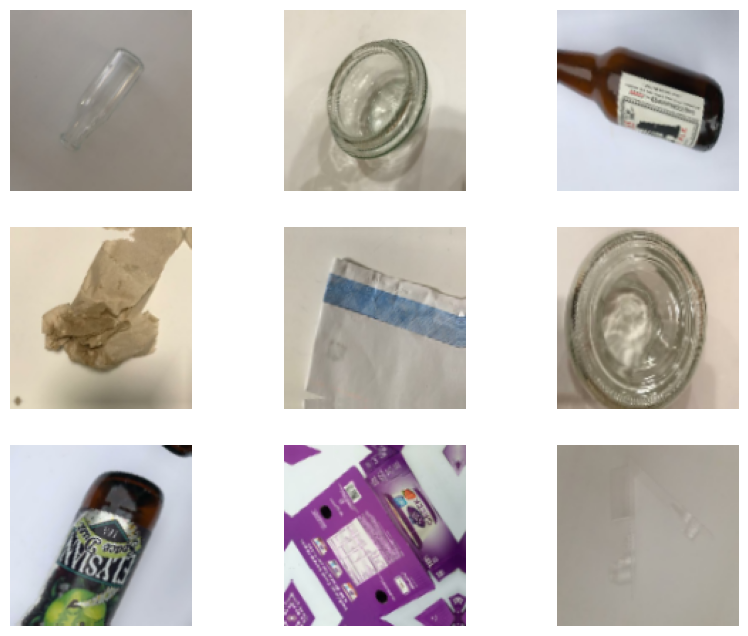

In [8]:
# See augmented images from one batch
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    break

In [9]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load EfficientNetV2B2 with pretrained weights
base_model = EfficientNetV2B2(
    include_top=False,  # We’ll add our own classifier
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model (initial training phase)
base_model.trainable = False

# Build the full model
inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # Optional, for more augmentation
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 968ms/step - accuracy: 0.3926 - loss: 1.5254 - val_accuracy: 0.7564 - val_loss: 0.8151
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 747ms/step - accuracy: 0.6878 - loss: 0.8899 - val_accuracy: 0.7624 - val_loss: 0.6899
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 748ms/step - accuracy: 0.7390 - loss: 0.7736 - val_accuracy: 0.8020 - val_loss: 0.6089
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 750ms/step - accuracy: 0.7584 - loss: 0.6754 - val_accuracy: 0.8059 - val_loss: 0.5804
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 755ms/step - accuracy: 0.7755 - loss: 0.6317 - val_accuracy: 0.8099 - val_loss: 0.5761
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 770ms/step - accuracy: 0.7998 - loss: 0.6219 - val_accuracy: 0.8040 - val_loss: 0.5580
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 749ms/step - accuracy: 0.7921 - loss: 0.5985 - val_accuracy: 0.8218 - val_loss: 0.5309
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 758ms/step - accuracy: 0.7933 - loss: 0.5733 - val_acc

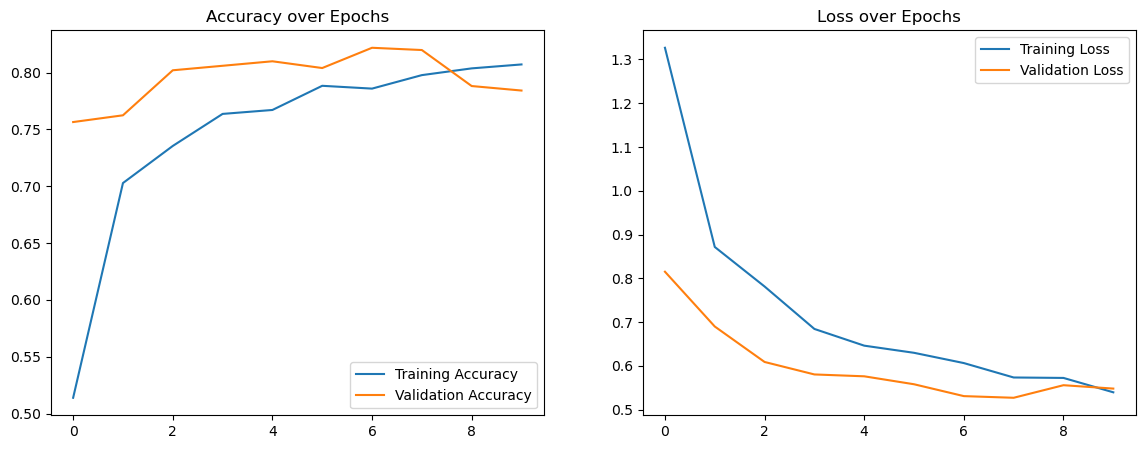

In [11]:
# Plot accuracy & loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


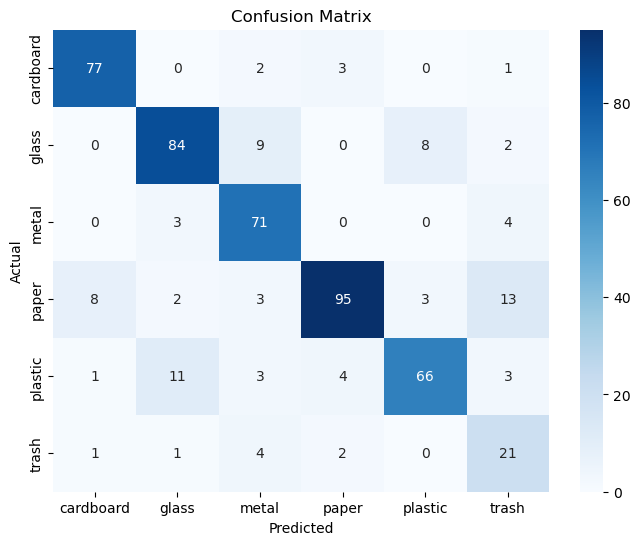

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.89      0.93      0.91        83
       glass       0.83      0.82      0.82       103
       metal       0.77      0.91      0.84        78
       paper       0.91      0.77      0.83       124
     plastic       0.86      0.75      0.80        88
       trash       0.48      0.72      0.58        29

    accuracy                           0.82       505
   macro avg       0.79      0.82      0.80       505
weighted avg       0.84      0.82      0.82       505



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 1: Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Step 2: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [13]:
# Save in modern Keras format
model.save("garbage_classifier_model.keras")

In [14]:
from tensorflow.keras.models import load_model

# Try loading the saved model
model_loaded = load_model("garbage_classifier_model.keras")

print("Model loaded successfully")

Model loaded successfully


In [15]:
#Model_Building_EfficientNetV2B2

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [17]:
# Dataset path
data_dir = "dataset"
img_height = 128
img_width = 128
batch_size = 32

# Load train and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check classes
class_names = train_ds.class_names
print("Classes:", class_names)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [18]:
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Data Augmentation Block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply preprocessing
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

# Prefetch to improve performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Data augmentation and preprocessing done.")

Data augmentation and preprocessing done.


In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Create datasets again without prefetch for now
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names BEFORE prefetching
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Extract all labels from dataset
train_labels = []
for _, labels in train_ds_raw.unbatch():
    train_labels.append(int(labels.numpy()))

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print class weights nicely
for i, name in enumerate(class_names):
    print(f"{name}: {class_weights_dict[i]:.2f}")

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
cardboard: 1.05
glass: 0.85
metal: 1.02
paper: 0.72
plastic: 0.86
trash: 3.12


In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class names BEFORE prefetching
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Extract all labels from training dataset
train_labels = []
for _, labels in train_ds_raw.unbatch():
    train_labels.append(int(labels.numpy()))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print class weights nicely
for i, name in enumerate(class_names):
    print(f"{name}: {class_weights_dict[i]:.2f}")

cardboard: 1.05
glass: 0.85
metal: 1.02
paper: 0.72
plastic: 0.86
trash: 3.12


In [21]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

# Load the EfficientNetV2B2 base model
base_model = EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the base model so it won't train initially
base_model.trainable = False

# Build the model
inputs = Input(shape=(128, 128, 3))
x = data_augmentation(inputs)  # Use the augmentation layer we created earlier
x = base_model(x, training=False)  # Pass through EfficientNet
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)  # 6 classes

model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [22]:
# Save raw datasets before prefetching
train_ds_raw = train_ds
val_ds_raw = val_ds

In [23]:
# Train the model
history = model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=10,
    class_weight=class_weights_dict
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 879ms/step - accuracy: 0.4010 - loss: 1.4908 - val_accuracy: 0.7485 - val_loss: 0.7923
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 731ms/step - accuracy: 0.7018 - loss: 0.8359 - val_accuracy: 0.7921 - val_loss: 0.6436
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 733ms/step - accuracy: 0.7732 - loss: 0.6819 - val_accuracy: 0.8059 - val_loss: 0.5828
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 740ms/step - accuracy: 0.7894 - loss: 0.6065 - val_accuracy: 0.8139 - val_loss: 0.5617
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 738ms/step - accuracy: 0.7924 - loss: 0.5790 - val_accuracy: 0.8158 - val_loss: 0.5386
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 758ms/step - accuracy: 0.8177 - loss: 0.5278 - val_accuracy: 0.8238 - val_loss: 0.5321
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 749ms/step - accuracy: 0.8284 - loss: 0.5118 - val_accuracy: 0.8218 - val_loss: 0.5103
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 733ms/step - accuracy: 0.8296 - loss: 0.4858 - val_accu

In [24]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds_raw)
print(f"Validation Accuracy: {val_accuracy:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 570ms/step - accuracy: 0.8114 - loss: 0.5155
Validation Accuracy: 0.81


In [25]:
model.save("garbage_classifier_model_week2.keras")

In [26]:
from tensorflow.keras.models import load_model

# Try loading the saved model
model_loaded = load_model("garbage_classifier_model.keras")

print("Model loaded successfully")

Model loaded successfully


In [27]:
#Final_Evaluation_and_Deployment

In [28]:
#Model Tuning and Testing
import tensorflow as tf

data_dir = "C:/Users/Mr/Garbage_Classification_Project/dataset"
img_height, img_width = 128, 128
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [29]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, models

base_model = EfficientNetV2B2(input_shape=(128, 128, 3),
                               include_top=False,
                               weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 90s 827ms/step - accuracy: 0.4908 - loss: 1.3522 - val_accuracy: 0.7980 - val_loss: 0.6760
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.7889 - loss: 0.6546 - val_accuracy: 0.8238 - val_loss: 0.5460
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.8326 - loss: 0.5210 - val_accuracy: 0.8396 - val_loss: 0.4963
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.8524 - loss: 0.4621 - val_accuracy: 0.8436 - val_loss: 0.4657
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 696ms/step - accuracy: 0.8482 - loss: 0.4236 - val_accuracy: 0.8515 - val_loss: 0.4499
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 704ms/step - accuracy: 0.8846 - loss: 0.3701 - val_accuracy: 0.8554 - val_loss: 0.4342
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 697ms/step - accuracy: 0.8987 - loss: 0.3561 - val_accuracy: 0.8653 - val_loss: 0.4211
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.8918 - loss: 0.3391 - val_accu

In [32]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - accuracy: 0.8760 - loss: 0.3835
Validation Accuracy: 0.87


In [33]:
model.save("best_garbage_classifier_model.keras")
print("Model saved successfully as best_garbage_classifier_model.keras")

Model saved successfully as best_garbage_classifier_model.keras


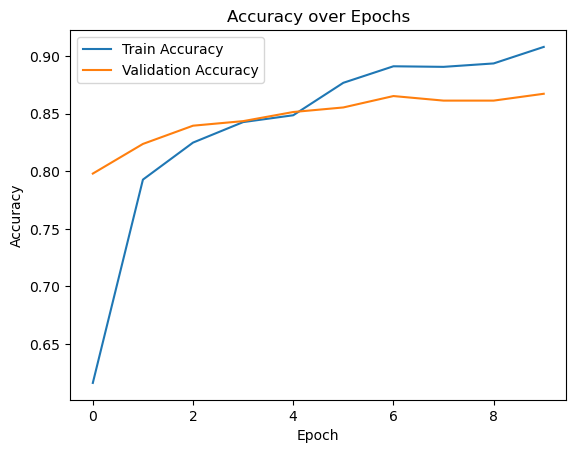

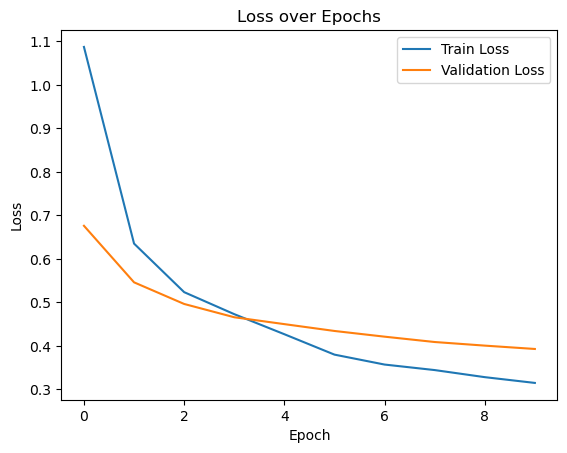

In [34]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [36]:
class_names = train_ds.class_names
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
import numpy as np
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
              precision    recall  f1-score   support

   cardboard       0.92      0.92      0.92        83
       glass       0.89      0.86      0.88       103
       metal       0.83      0.87      0.85        78
       paper       0.86      0.91      0.89       124
     plastic       0.88      0.82      0.85        88
       trash       0.74      0.69      0.71        29

In [38]:
import os
import csv
import numpy as np
from tensorflow.keras.preprocessing import image

custom_dir = "C:/Users/Mr/Garbage_Classification_Project/custom_test"
output_csv = "custom_predictions.csv"
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Predicted Class'])

    for img_name in os.listdir(custom_dir):
        img_path = os.path.join(custom_dir, img_name)

        if os.path.isdir(img_path):
            continue

        try:
            img = image.load_img(img_path, target_size=(128, 128))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            predictions = model.predict(img_array)
            predicted_class = class_names[np.argmax(predictions)]

            writer.writerow([img_name, predicted_class])
        except Exception as e:
            print(f"Error with {img_name}: {e}")

print("Predictions saved successfully to custom_predictions.csv")

Predictions saved successfully to custom_predictions.csv


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.92      0.92      0.92        83
       glass       0.89      0.86      0.88       103
       metal       0.83      0.87      0.85        78
       paper       0.86      0.91      0.89       124
     plastic       0.88      0.82      0.85        88
       trash       0.74      0.69      0.71        29

    accuracy                           0.87       505
   macro avg       0.85      0.85      0.85       505
weighted avg       0.87      0.87      0.87       505



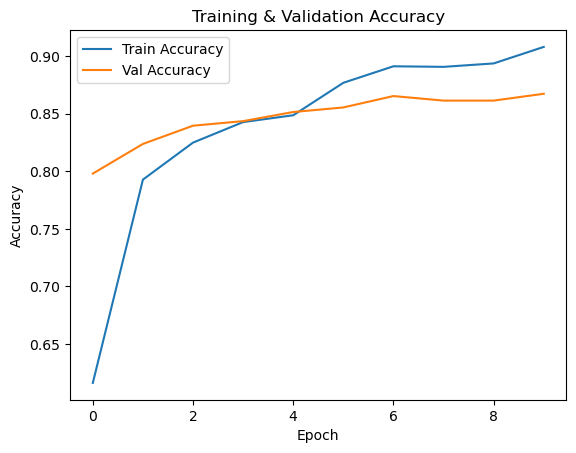

In [40]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
import os

# Create folder if it doesn't exist
os.makedirs("C:/Users/Mr/Garbage_Classification_Project/outputs", exist_ok=True)
plt.savefig("C:/Users/Mr/Garbage_Classification_Project/outputs/training_accuracy_plot.png")
plt.savefig('outputs/training_accuracy_plot.png')
plt.show()

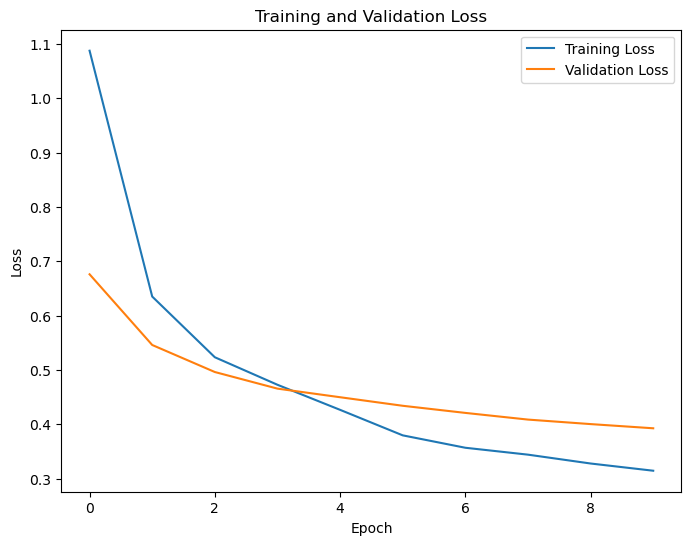

In [41]:
# Plot and save training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Create the outputs directory if it doesn't exist
os.makedirs("C:/Users/Mr/Garbage_Classification_Project/outputs", exist_ok=True)

# Save the loss plot
plt.savefig("C:/Users/Mr/Garbage_Classification_Project/outputs/training_loss_plot.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
Classification Report:

              precision    recall  f1-score   support

   cardboard       0.92      0.92      0.92        83
       glass       0.89      0.86      0.88       103
       metal       0.83      0.87      0.85        78
       paper       0.86      0.91      0.89       124
     plastic       0.88      0.82      0.85        88
       trash       0.74    

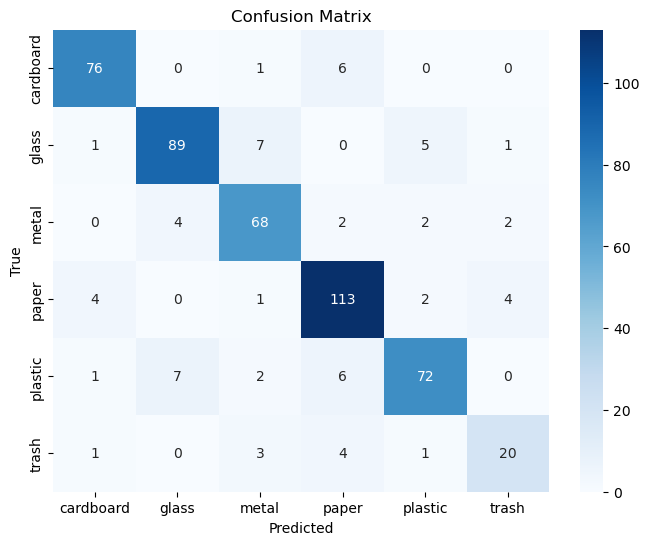

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Get class names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("C:/Users/Mr/Garbage_Classification_Project/outputs/confusion_matrix.png")
plt.show()

In [43]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {val_acc:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 561ms/step - accuracy: 0.8792 - loss: 0.3830

Final Validation Accuracy: 0.87


In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define your dataset path
dataset_path = "C:/Users/Mr/Garbage_Classification_Project/dataset"

# Load training and validation datasets (adjust batch_size and image size as per your training settings)
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Use validation set as test dataset for final evaluation (or load another test folder if available)
test_ds_eval = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [50]:
from tensorflow.keras.models import load_model
model = load_model("best_garbage_classifier_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


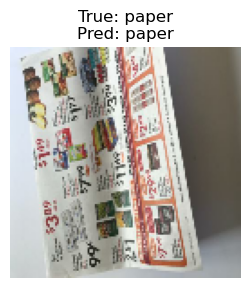

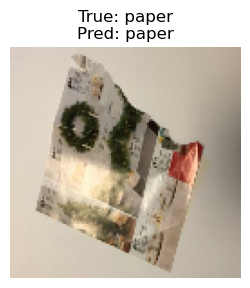

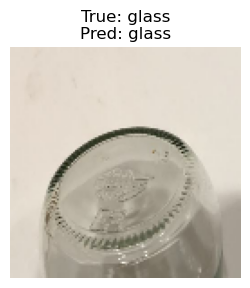

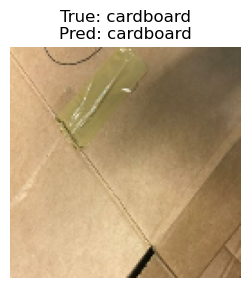

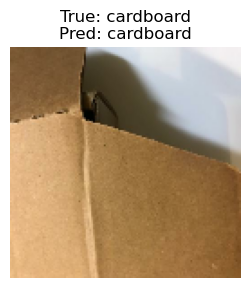

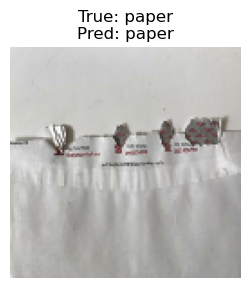

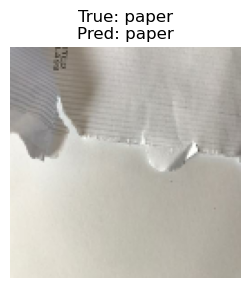

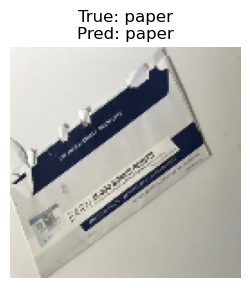

In [51]:
for images, labels in test_ds_eval.take(1):  
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):  
        plt.figure(figsize=(3, 3))
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()

In [52]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {val_acc:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 683ms/step - accuracy: 0.8647 - loss: 0.4126

Final Validation Accuracy: 0.87


In [53]:
model.save("C:/Users/Mr/Garbage_Classification_Project/best_garbage_classifier_model.keras")
print("Final model saved as 'best_garbage_classifier_model.keras'")

Final model saved as 'best_garbage_classifier_model.keras'


In [54]:
pip install gradio

In [55]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load your trained model
model = load_model("best_garbage_classifier_model.keras")

# Define class names in the same order as during training
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Define the image preprocessing function
def preprocess_image(img):
    img = img.resize((128, 128))  # Resize to model input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0  # Normalize
    return img

# Define the prediction function
def classify_garbage(input_img):
    processed_img = preprocess_image(input_img)
    prediction = model.predict(processed_img)
    class_index = np.argmax(prediction)
    class_label = class_names[class_index]
    confidence = round(float(np.max(prediction)) * 100, 2)
    return f"{class_label} ({confidence}%)"

# Gradio interface
interface = gr.Interface(
    fn=classify_garbage,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Classification using EfficientNetV2B2",
    description="Upload a garbage image and the model will predict its category."
)

# Launch app
interface.launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [56]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load your trained model
model = load_model("best_garbage_classifier_model.keras")

# Define class names in the same order as during training
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Define the image preprocessing function
def preprocess_image(img):
    img = img.resize((128, 128))  # Resize to model input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0  # Normalize
    return img

# Define the prediction function
def classify_garbage(input_img):
    processed_img = preprocess_image(input_img)
    prediction = model.predict(processed_img)
    class_index = np.argmax(prediction)
    class_label = class_names[class_index]
    confidence = round(float(np.max(prediction)) * 100, 2)
    return f"{class_label} ({confidence}%)"

# Gradio interface
interface = gr.Interface(
    fn=classify_garbage,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Classification using EfficientNetV2B2",
    description="Upload a garbage image and the model will predict its category."
)

# Launch app
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://6ba40fec05cba4f940.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
